# Systemy uczące się - Zad. dom. 2: Naiwny klassyfikator Bayesa

### Autor rozwiązania: Dominik Maćkowiak, 151915

Ten notebook zawiera dwa zadania związane z klasyfikatorem naiwnego Bayesa, oprócz implementacji zawiera on równie pytania na które trzeba odpowiedzieć.

## Zadanie 1
Zadanie polega na implementacji klasyfikatora naiwnego Bayesa dla zmiennych ciągłych gdzie za rozkłady cechy przyjmij rozkłady normalne.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("ggplot")

Do testowania twojego rozwiązania użyj trzech generatorów danych sztucznych `generate1`, `generate2` oraz `generate3` (funkcje te przyjmują jako argument liczbę elementów do wygenerowania z każdej klasy - domyślnie $N=100$). Sposób ich wywołania jest przedstawiony poniżej:

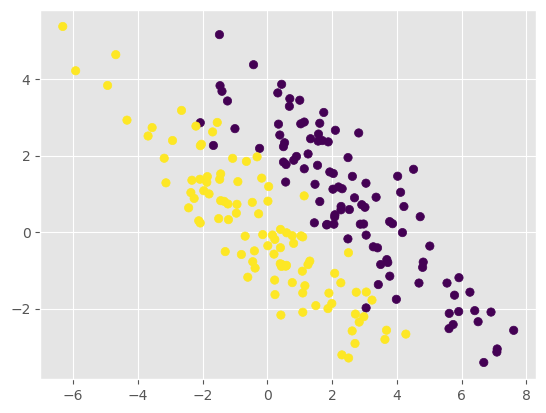

In [31]:
from helpers import generate1, generate2, generate3

X, y = generate3()
plt.scatter(X[:,0], X[:,1], c = y)

W implementacji będzie przydatna klasa `norm` z pakietu `scipy`, która zwraca wartości funkcji gęstości prawdopodobieństwa rozkładu normalnego dla zmiennych ciągłych.

In [3]:
from  scipy.stats import norm

# (X, mean, std)
norm.pdf(5, 0, 1) #gęstość prawd. dla 5 z rozkładu standardowego
norm.logpdf(5, 0, 1) #logarytm gęstości prawd. dla 5 z rozkładu standardowego

np.float64(-13.418938533204672)

Zaimplementuj klasyfikator naiwnego Bayesa dla zmiennych ciągłych. Pamiętaj o zabezpieczniu się przed problemem wynikającym z mnożenia wielu małych liczb (prawdopodobieństw).

In [23]:

class GaussianNaiveBayes():
    def __init__(self):
        self.means: np.ndarray = {} 
        # Słownik, który docelowo powinien zawierać tablicę/wektor warunkowych średnich dla każdego atrybutu 
        # Każda tablica/wektor powinna być typu np.array
        # np. 1) means[1] powinno zawierać wektor średnich wartości atrybutów  dla klasy o indeksie 1
        #     2) means[0][1] powinno zawierać średnią 1 atrybutu dla klasy o indeksie 0
        # (Możesz spróbować zaimplementować efektywniejszą implementację używając macierzy)
        self.stds: np.ndarray = {} 
        # Analogiczna struktura dla odchyleń standardowych
        self.class_log_prob: np.ndarray = None 
        # Wektor zawierający logarytmy prawdopodobieństwa dla każdej z klas 
        # np. class_log_prob[1] zawiera logarytm prawdopodobieństwa, że klasa jest równa 1 P(C=1)
        
    def fit(self, X: np.ndarray[np.floating], y: np.ndarray[np.integer]):
        # TWÓJ KOD TUTAJ - proces uczenia czyli uzupełniania struktur zainicjaliowanych w init()
        #                  odpowiednimi wartościami
        # X jest macierzą gdzie każdy wiersz zawiera kolejną obserwację (typ np.array) 
        # y jest wektorem wartości indeksu klasy (0 lub 1). Jego wartości odpowiadają kolejnym wierszom X

        # Obliczenie prawdopodobieństwa wystąpienia każdej klasy
        self.class_log_prob = np.log(np.bincount(y) / len(y))

        # Zainicjalizowanie tablic na średnie i odchylenia standardowe
        self.means = np.zeros((X.shape[1], len(self.class_log_prob)))
        self.stds = np.zeros((X.shape[1], len(self.class_log_prob)))

        # Obliczenie średnich i odchyleń standardowych dla każdej klasy
        for c_i, c in enumerate(self.class_log_prob):
            for ch_i in range(X.shape[1]):
                self.means[ch_i][c_i] = np.mean(X[y == c_i, ch_i])
                self.stds[ch_i][c_i] = np.std(X[y == c_i, ch_i])
    
    def probability_for_variant(self, x: np.integer, ch: np.integer, c: np.integer) -> np.floating:
        return norm.pdf(x, self.means[ch][c], self.stds[ch][c])

    def probability_for_class(self, X: np.ndarray[np.floating], c: np.integer) -> np.ndarray[np.floating]:
        variant_probabilities = [self.probability_for_variant(x, ch_i, c) for ch_i, x in enumerate(X)]
        numerator = np.prod(variant_probabilities) * self.class_log_prob[c]
        denominator = 0.0
        for c_other_i, c_other in enumerate(self.class_log_prob):
            variant_probabilities = [self.probability_for_variant(x, ch_i, c_other_i) for ch_i, x in enumerate(X)]
            denominator += np.prod(variant_probabilities) * self.class_log_prob[c_other_i]
        return numerator / denominator

    def predict_proba(self, X: np.ndarray[np.floating]) -> np.ndarray[np.floating]:
        # TWÓJ KOD TUTAJ - predykcja - zwrócenie prawdopodobieństwa dla każdej klasy i każdej obserwacji
        # Funkcja powinna zwrócić macierz o dwóch kolumnach (dwie klasy) w której kolejne wiersze 
        # zawierają prawdopodobieństwa P(c|x) przynależności dla klas dla kolejnych obserwacji w macierzy X

        # Inicjalizacja macierzy prawdopodobieństw
        prob = np.zeros((X.shape[0], len(self.class_log_prob)))

        # Obliczenie prawdopodobieństw dla każdej klasy
        for v_i, v in enumerate(X):
            for c_i, c in enumerate(self.class_log_prob):
                prob[v_i][c_i] = self.probability_for_class(v, c_i)

        return prob
    
    def predict(self, X: np.ndarray[np.floating]):
        # Gotowa funkcja wybierająca klasę z największym prawdopodobieństwem
        prob = self.predict_proba(X)
        return np.argmax(prob, axis=1)


Przetestuj twój klasyfikator na wygenerowanych wcześniej danych.

In [32]:
gnb = GaussianNaiveBayes()
gnb.fit(X,y)

#Trafność na zbiorze uczącym
prediction = gnb.predict(X)
np.mean(gnb.predict(X) == y)

np.float64(0.825)

Narysowanie nauczonego klasyfikatora

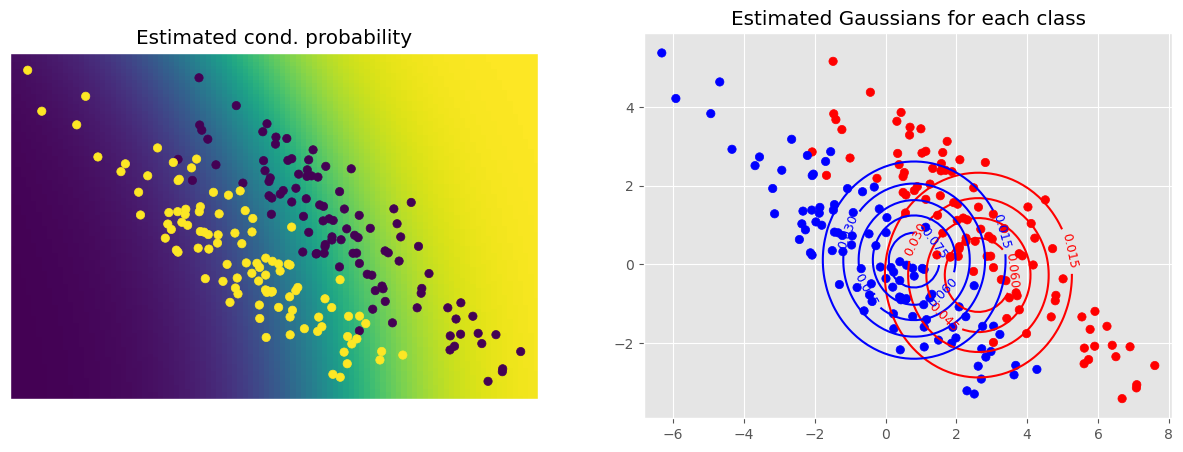

In [33]:
from helpers import plotGaussianBayes
plotGaussianBayes(X, y, gnb)

Użyj funkcji do generowania danych, aby wygenerować zbiór testowy oraz sprawdź na nim trafność klasyfikacji metody.

In [34]:
X_test, y_test = generate3(1000)
np.mean(gnb.predict(X_test) == y_test)

np.float64(0.8225)

**Ćwiczenia**
 - Pamiętaj o przetestowaniu Twojego algorytmu dla wszystkich trzech generatorów danych. W których ze zbiorów założenie o warunkowej niezależności zmiennych jest spełnione? Jak brak spełnienia tego założenia wpływa na działanie klasyfikatora?
 - Z pliku `helpers` zaimportuj klasę `GaussianBayes` (identyczna obsługa jak tej zaimplementowanej przez Ciebie). Klasa implementuje algorytm Bayesa bez założenia o niezależności zmiennych (ale z założeniem o normalności rozkładów). Porównaj wyniki - szczególnie dla zbiorów dla których założenie o warunkowej niezależności zmiennych nie jest spełnione.
 - Klasyfikatora `GaussianBayes` nie można wytrenować na zbiorach które mają mniej niż 3 przykłady dla każdej z klas. Jak myślisz dlaczego? Jak ten problem będzie się zmieniał dla zbiorów o wysokiej liczbie cech?
 - Nawet używając klasyfikatora `GaussianBayes`, który zakłada kompletny model zależności i prawidłowy rozkład danych (nasze dane są generowane z rozkładów normalnych) - często nie jest w stanie uzyskać 100% trafności nawet na zbiorze uczącym. Jak myślisz, dlaczego? 
 - Czy gdyby przepisać do klasyfikatora prawdziwe wartości średnich i macierz wariancji-kowariancji cech (z generatora) - uzyskalibyśmy 100% trafność? Co możemy powiedzieć o takim klasyfikatorze? Czy jest możliwe uzyskanie klasyfikatora bardziej trafnego niż taki? 
 
 Odpowiedzi na dwa ostatnie pytania zostaną sprawdzone: wpisz swoje odpowiedzi poniżej.

In [35]:
from helpers import GaussianBayes
X1, y1 = generate1()
X2, y2 = generate2()
X3, y3 = generate3()

gnb1 = GaussianBayes()
gnb1.fit(X1, y1)
gnb2 = GaussianBayes()
gnb2.fit(X2, y2)
gnb3 = GaussianBayes()
gnb3.fit(X3, y3)

X1_test, y1_test = generate1(1000)
X2_test, y2_test = generate2(1000)
X3_test, y3_test = generate3(1000)

np.mean(gnb1.predict(X1_test) == y1_test), np.mean(gnb2.predict(X2_test) == y2_test), np.mean(gnb3.predict(X3_test) == y3_test)

(np.float64(0.995), np.float64(1.0), np.float64(0.965))

4. Jeśli rozkłady dwóch klas częściowo się pokrywają (mają wspólne obszary o wysokim prawdopodobieństwie), to nawet idealny klasyfikator probabilistyczny może popełniać błędy. Bo w takich przypadkach punkty w „obszarze granicznym” mogą z dużym prawdopodobieństwem należeć do obu klas, a algorytm wybiera klasę tylko na podstawie maksymalnego prawdopodobieństwa.

5. Uzyskalibyśmy 100% trafność? Niestety nie, bo nawet mając idealny model, jeśli rozkłady klas częściowo się nakładają, zawsze istnieje część obserwacji, która jest „bliższa” granicy decyzyjnej. Nawet jeśli punkt został wygenerowany z klasy A, ale wylosował się z obszaru, gdzie rozkład klasy B dominuje (bo rozkłady się przecinają), to klasyfikator z pełną wiedzą przypisze go do klasy B. Taki klasyfikator jest teoretycznie optymalny — oznacza to, że nie istnieje inny klasyfikator o niższym średnim błędzie klasyfikacji niż klasyfikator Bayesowski. Tak więc nie dało by się uzyksać klasyfikatora bardziej trafnego niż ten.


# Zadanie 2
Klasyfikator naiwnego Bayesa często jest używany do klasyfikacji tekstów. Przetestuj działanie algorytmów na podanym rzeczywistym zbiorze danych: 
> The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date.

Podany zbiór jest wieloklasowy, więc poniższy kod wybiera z niego podzbiór postów tylko z dwóch tematów.

In [36]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

categories = [  'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

vectorizer = TfidfVectorizer(binary=True, use_idf=False, norm=None) # Przekształcenie tekstu na cechy binarne
vectors = vectorizer.fit_transform(newsgroups_train.data)
vectors_test = vectorizer.transform(newsgroups_test.data)
vectors = vectors.toarray()
vectors_test = vectors_test.toarray()

Dokumenty w zbiorze można wyświetlić w następujący sposób.

In [37]:
newsgroups_train.data[0:3]

['From: ab@nova.cc.purdue.edu (Allen B)\nSubject: Re: thining algorithm\nOrganization: Purdue University\nLines: 15\n\nIn article <1q7615INNmi@shelley.u.washington.edu> kshin@stein.u.washington.edu  \n(Kevin Shin) writes:\n> I am trying obtain program to preprocess handwriting characters.\n> Like thining algorithm, graph alogrithm.\n> Do anyone know where I can obtain those?\n\nI usually use "Algorithms for graphics and image processing" by\nTheodosios Pavlidis, but other people here got them same idea and now\n3 of 4 copies in the libraries have been stolen!\n\nAnother reference is "Digital Image Processing" by Gonzalez and\nWintz/Wood, which is widely available but a little expensive ($55\nhere- I just checked today).\n\nab\n',
 "From: stephens@geod.emr.ca (Dave Stephenson)\nSubject: Re: Clementine Science Team Selected\nNntp-Posting-Host: ngis.geod.emr.ca\nOrganization: Dept. of Energy, Mines, and Resources, Ottawa\nLines: 32\n\nnickh@CS.CMU.EDU (Nick Haines) writes:\n\n>In article 

Analogicznie możemy uzyskać dostęp do informacji o klasach.

In [38]:
newsgroups_train.target[0:3]

array([0, 1, 0])

i do "zbinaryzowanego" tekstu

In [39]:
vectors[0:3]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(3, 23882))

Wytrenuj klasyfikator Naiwnego Bayesa z rozmywaniem estymat (patrz pakiet `sklearn`) i sprawdż jego trafność na zbiorze uczącym i testowym.

In [40]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Stworzenie i nauczenie modelu
model = MultinomialNB(alpha=1.0)
model.fit(vectors, newsgroups_train.target)

# Ewaluacja na zbiorze uczącym
y_train_pred = model.predict(vectors)
train_acc = accuracy_score(newsgroups_train.target, y_train_pred)
print(train_acc)

# Ewaluacja na zbiorze testowym
y_test_pred = model.predict(vectors_test)
test_acc = accuracy_score(newsgroups_test.target, y_test_pred)
print(test_acc)

0.9957519116397621
0.9616858237547893


**Ćwiczenia**
 - Dlaczego klasyfikator Naiwnego Bayesa dość dobrze sprawdza się do powyższego zadania i analogicznych?
 - Przeanalizuj wartości estymat prawdopodobieństw. Które cechy/słowa są najlepszymi wskaźnikami dla podanych klas? Jakie słowa bardzo słabo wskazują na którąkolwiek z klas?
 - Czy byłoby możliwe wytrenowanie równie skutecznego klasyfikatora z mniejszą liczbą cech? W jaki sposób można by to uzyskać?
 - Analizowany zbiór jest oryginalnie wieloklasowy z tego powodu możemy go wykorzystać do wielu testów wybierając różne pary klas. Pełna lista tematów: 'alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc'
 - Czy są pary tematów dla których ten klasyfikator działa znacząco gorzej?
 - Jakie są zalety stosowania klasyfikatora Bayesa dla tego problemu (i w ogólności)? Czy do tego problemu sprawdziłyby się reguły lub drzewa decyzyjne? Dlaczego?
 
 Odpowiedzi na kropki 1, 3 i 6 wpisz poniżej - zostaną sprawdzone.

1. Założenie o niezależności cech jest tutaj trafne. Mamy tutaj cechy binarne, gdzie 1 to wystąpienie słowa, a 0 to brak. Oczywiście między wystąpieniem jakichś słów może istnieć pewna zależność, ale tutaj jest to pomijalne. Do tego wystąpienie niektórych słów praktycznie jednoznacznie wyznaczy nam już klasę. Np. jakby nam się pojawiły słowa: piłka, bramka, zawodnik to możemy to zakfalifikować to klasy 'sport'
3. Można by to zrobić pozbywając się słów, które w ogóle nie mają wpływu na klasyfikację
6. Bayes jest prosty i szybki do nauczenia. Jeśli dane są niezależne to jest wysoka trafność. W teorii można by zrobić drzewa, ale takie drzewa byłyby ogromne. Musielbyśmy mieć rozgałęzienia typu 'Jeśli słowo X występuję i słowo Y nie występuje, to [i podział drzewa]'. Wytrenowanie takiego drzewa, czyli zrobienie podziałów, również zajęłoby dużo czasu. Do tego istnieje szansa że drzewo może się przeuczyć. Dlatego w praktyce nie stosowałbym drzew decyzyjnych do takich problemów.